# Crypto AI Backtest (Multi-Coin)

This notebook trains an AI model on BTC then applies it to BTC, GALA and XRP. It backtests a Bollinger+AI-filtered strategy on each coin and shows performance metrics and equity curves.

**Run in Google Colab or Jupyter.** Uncomment the pip installs if needed.

In [46]:
# Install packages if running in a fresh environment
!pip install yfinance pandas numpy ta scikit-learn joblib vectorbt matplotlib


In [47]:
import yfinance as yf
import pandas as pd
import numpy as np
import ta
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib
import vectorbt as vbt
import matplotlib.pyplot as plt

pd.options.display.max_columns = 100


## Step 1 — Download 30m OHLCV data for BTC, GALA, XRP (60 days)

In [48]:
symbols = ['BTC-USD', 'GALA-USD', 'XRP-USD']
interval = '30m'
period = '60d'

price_data = {}
for sym in symbols:
    print(f'Downloading {sym}...')
    df = yf.download(sym, period=period, interval=interval, progress=False)
    if df.empty:
        print(f'Warning: no data for {sym}')
    price_data[sym] = df.dropna()

# show samples
for s, df in price_data.items():
    print(s, 'rows:', len(df))
    display(df.head())


/tmp/ipython-input-2868919966.py:8: FutureWarning:

YF.download() has changed argument auto_adjust default to True



/tmp/ipython-input-2868919966.py:8: FutureWarning:

YF.download() has changed argument auto_adjust default to True



/tmp/ipython-input-2868919966.py:8: FutureWarning:

YF.download() has changed argument auto_adjust default to True



BTC-USD rows: 2840


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Datetime,,,,,
2025-07-28 00:00:00+00:00,119666.906250,119684.445312,119391.039062,119443.953125,1335595008
2025-07-28 00:30:00+00:00,119329.554688,119672.867188,119202.328125,119672.867188,1386631168
2025-07-28 01:00:00+00:00,119366.062500,119515.492188,119129.507812,119252.304688,1314926592
2025-07-28 01:30:00+00:00,119043.179688,119425.992188,119019.257812,119425.992188,2064678912
2025-07-28 02:00:00+00:00,119514.328125,119514.328125,119066.179688,119066.179688,1844445184


GALA-USD rows: 2836


Price,Close,High,Low,Open,Volume
Ticker,GALA-USD,GALA-USD,GALA-USD,GALA-USD,GALA-USD
Datetime,,,,,
2025-07-28 00:00:00+00:00,0.018466,0.018499,0.018343,0.018348,2641976
2025-07-28 00:30:00+00:00,0.018372,0.018487,0.018330,0.018457,4361656
2025-07-28 01:00:00+00:00,0.018145,0.018304,0.018145,0.018304,2467960
2025-07-28 01:30:00+00:00,0.018075,0.018148,0.018061,0.018148,255720
2025-07-28 02:00:00+00:00,0.018250,0.018250,0.018078,0.018093,2562280


XRP-USD rows: 2840


Price,Close,High,Low,Open,Volume
Ticker,XRP-USD,XRP-USD,XRP-USD,XRP-USD,XRP-USD
Datetime,,,,,
2025-07-28 00:00:00+00:00,3.273717,3.273717,3.229481,3.240680,145593344
2025-07-28 00:30:00+00:00,3.270307,3.280304,3.260545,3.273969,260034048
2025-07-28 01:00:00+00:00,3.243617,3.270296,3.243205,3.270296,127732224
2025-07-28 01:30:00+00:00,3.237179,3.243737,3.227086,3.243737,149325824
2025-07-28 02:00:00+00:00,3.258971,3.258971,3.237911,3.237911,122406400


Step-2




In [49]:
def build_features(df):
    df = df.copy()
    close = df['Close'].squeeze()  # Convert to Series if it's a DataFrame
    volume = df['Volume'].squeeze()
    open_ = df['Open'].squeeze()
    high = df['High'].squeeze()
    low = df['Low'].squeeze()

    df['rsi'] = ta.momentum.RSIIndicator(close).rsi()
    macd = ta.trend.MACD(close)
    df['macd'] = macd.macd()
    df['macd_signal'] = macd.macd_signal()
    bb = ta.volatility.BollingerBands(close)
    df['bb_mid'] = bb.bollinger_mavg()
    df['bb_high'] = bb.bollinger_hband()
    df['bb_low'] = bb.bollinger_lband()
    df['bb_width'] = (df['bb_high'] - df['bb_low']) / df['bb_mid']
    df['percent_b'] = (close - df['bb_low']) / (df['bb_high'] - df['bb_low'])
    df['volume_change'] = volume.pct_change()

    body = abs(close - open_)
    candle_range = high - low
    upper_shadow = high - np.maximum(open_, close)
    lower_shadow = np.minimum(open_, close) - low

    df['shooting_star'] = ((body <= 0.3 * candle_range) & (upper_shadow >= 2 * body) & (lower_shadow <= 0.2 * body)).astype(int)
    df['hammer'] = ((body <= 0.3 * candle_range) & (lower_shadow >= 2 * body) & (upper_shadow <= 0.2 * body)).astype(int)

    return df.dropna()

## Step 3 — Label data for training

Label definition: a future horizon of 3 bars (~90 minutes). Label = 1 if future return > 0.2% (0.002), else 0. You can tune horizon & threshold.

In [50]:
horizon = 3
label_threshold = 0.002

labeled = {}

for sym, df in price_data.items():
    print(f'Preparing data for {sym}...')

    df_feat = build_features(df)
    df_feat['future_return'] = df_feat['Close'].shift(-horizon) / df_feat['Close'] - 1
    df_feat = df_feat.dropna()
    df_feat['label'] = (df_feat['future_return'] > label_threshold).astype(int)

    labeled[sym] = df_feat

    print(sym, 'label distribution:')
    print(df_feat['label'].value_counts(normalize=True).to_string())

Preparing data for BTC-USD...
BTC-USD label distribution:
label
0    0.763252
1    0.236748
Preparing data for GALA-USD...
GALA-USD label distribution:
label
0    0.596792
1    0.403208
Preparing data for XRP-USD...
XRP-USD label distribution:
label
0    0.636828
1    0.363172


## Step 4 — Prepare features and train RandomForest

We use a modest feature set. Train on BTC and save model.

In [51]:
# Step 1: Use BTC-USD labeled data
train_df = labeled['BTC-USD'].copy()

# Define features
feature_cols = ['rsi', 'macd', 'bb_mid', 'bb_high', 'bb_low', 'bb_width',
                'percent_b', 'volume_change', 'shooting_star', 'hammer']

# Use one symbol for training (e.g., BTC-USD)
train_df = labeled['BTC-USD']

X = train_df[feature_cols].copy()
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
X = np.clip(X, -1e6, 1e6)

y = train_df['label']

# Time-aware split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Train model
model = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42)
model.fit(X_train, y_train)

print("✅ Model trained")

# Evaluate
print("\n📊 Classification Report:")
print(classification_report(y_test, model.predict(X_test)))

# Save
joblib.dump(model, "crypto_ai_model.pkl")
print("💾 Model saved to crypto_ai_model.pkl")

✅ Model trained

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       458
           1       0.00      0.00      0.00       101

    accuracy                           0.82       559
   macro avg       0.41      0.50      0.45       559
weighted avg       0.67      0.82      0.74       559

💾 Model saved to crypto_ai_model.pkl


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## Step 5 — Apply model to all symbols and backtest

We will generate AI signals (1=approve trade) and then backtest Bollinger entries filtered by AI approval (entry only when price <= lower band and ai==1). Exits are price >= upper band.

In [44]:
results = {}

for sym in labeled:
    print(f'\n📊 Processing {sym}...')
    df = labeled[sym].copy()

    # ✅ Flatten multi-index columns
    df.columns = ['_'.join(filter(None, col)).strip() if isinstance(col, tuple) else col for col in df.columns]

    # ✅ Prepare features
    X_sym = df[feature_cols].copy()
    X_sym = X_sym.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_sym = np.clip(X_sym, -1e6, 1e6)

    # ✅ Align
    if len(X_sym) != len(df):
        df = df.iloc[-len(X_sym):].copy()

    # ✅ Predict
    try:
        df['ai_signal'] = model.predict(X_sym)
    except Exception as e:
        print(f"❌ Prediction failed for {sym}: {e}")
        continue

    # ✅ Define correct Close column name
    close_col = f'Close_{sym}'
    required_cols = [close_col, 'bb_low', 'bb_high', 'ai_signal']

    print(f"{sym} columns before dropna:", df.columns.tolist())
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        print(f"❌ Skipping {sym}: missing columns {missing_cols}")
        continue

    # ✅ Clean up
    for col in required_cols:
        df[col] = df[col].replace([np.inf, -np.inf], np.nan)
    try:
        df = df.dropna(subset=required_cols)
    except KeyError as e:
        print(f"❌ Skipping {sym}: dropna failed - {e}")
        continue

    # ✅ Signals
    entries = (df[close_col] <= df['bb_low']) & (df['ai_signal'] == 1)
    exits = df[close_col] >= df['bb_high']

    entries_exec = entries.shift(1).fillna(False)
    exits_exec = exits.shift(1).fillna(False)

    # ✅ Backtest
    pf = vbt.Portfolio.from_signals(
        close=df[close_col],
        entries=entries_exec,
        exits=exits_exec,
        init_cash=10000,
        fees=0.001,
        slippage=0.0005,
        freq='30T'
    )

    stats = pf.stats()
    print(f'✅ Stats for {sym}')
    display(stats)
    results[sym] = pf


📊 Processing BTC-USD...
BTC-USD columns before dropna: ['Close_BTC-USD', 'High_BTC-USD', 'Low_BTC-USD', 'Open_BTC-USD', 'Volume_BTC-USD', 'rsi', 'macd', 'macd_signal', 'bb_mid', 'bb_high', 'bb_low', 'bb_width', 'percent_b', 'volume_change', 'shooting_star', 'hammer', 'future_return', 'label', 'ai_signal']


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

/tmp/ipython-input-1786029634.py:49: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/tmp/ipython-input-1786029634.py:50: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/usr/local/lib/python3.12/dist-packages/vectorbt/utils/datetime_.py:24: FutureWarning:

'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.



✅ Stats for BTC-USD


,0
Start,2025-07-28 16:30:00+00:00
End,2025-09-25 02:30:00+00:00
Period,58 days 03:30:00
Start Value,10000.0
End Value,10692.341151
Total Return [%],6.923412
Benchmark Return [%],-4.32389
Max Gross Exposure [%],100.0
Total Fees Paid,265.126992
Max Drawdown [%],2.748693



📊 Processing GALA-USD...
GALA-USD columns before dropna: ['Close_GALA-USD', 'High_GALA-USD', 'Low_GALA-USD', 'Open_GALA-USD', 'Volume_GALA-USD', 'rsi', 'macd', 'macd_signal', 'bb_mid', 'bb_high', 'bb_low', 'bb_width', 'percent_b', 'volume_change', 'shooting_star', 'hammer', 'future_return', 'label', 'ai_signal']


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

/tmp/ipython-input-1786029634.py:49: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/tmp/ipython-input-1786029634.py:50: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/usr/local/lib/python3.12/dist-packages/vectorbt/utils/datetime_.py:24: FutureWarning:

'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.



✅ Stats for GALA-USD


,0
Start,2025-07-28 16:30:00+00:00
End,2025-09-25 02:30:00+00:00
Period,55 days 20:00:00
Start Value,10000.0
End Value,7920.254065
Total Return [%],-20.797459
Benchmark Return [%],-13.458841
Max Gross Exposure [%],100.0
Total Fees Paid,572.123598
Max Drawdown [%],23.969702



📊 Processing XRP-USD...
XRP-USD columns before dropna: ['Close_XRP-USD', 'High_XRP-USD', 'Low_XRP-USD', 'Open_XRP-USD', 'Volume_XRP-USD', 'rsi', 'macd', 'macd_signal', 'bb_mid', 'bb_high', 'bb_low', 'bb_width', 'percent_b', 'volume_change', 'shooting_star', 'hammer', 'future_return', 'label', 'ai_signal']


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

/tmp/ipython-input-1786029634.py:49: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/tmp/ipython-input-1786029634.py:50: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/usr/local/lib/python3.12/dist-packages/vectorbt/utils/datetime_.py:24: FutureWarning:

'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.



✅ Stats for XRP-USD


,0
Start,2025-07-28 16:30:00+00:00
End,2025-09-25 02:30:00+00:00
Period,53 days 01:00:00
Start Value,10000.0
End Value,9454.927085
Total Return [%],-5.450729
Benchmark Return [%],-8.44161
Max Gross Exposure [%],100.0
Total Fees Paid,663.824819
Max Drawdown [%],14.293054


## Step 6 — Plot equity curves for all symbols

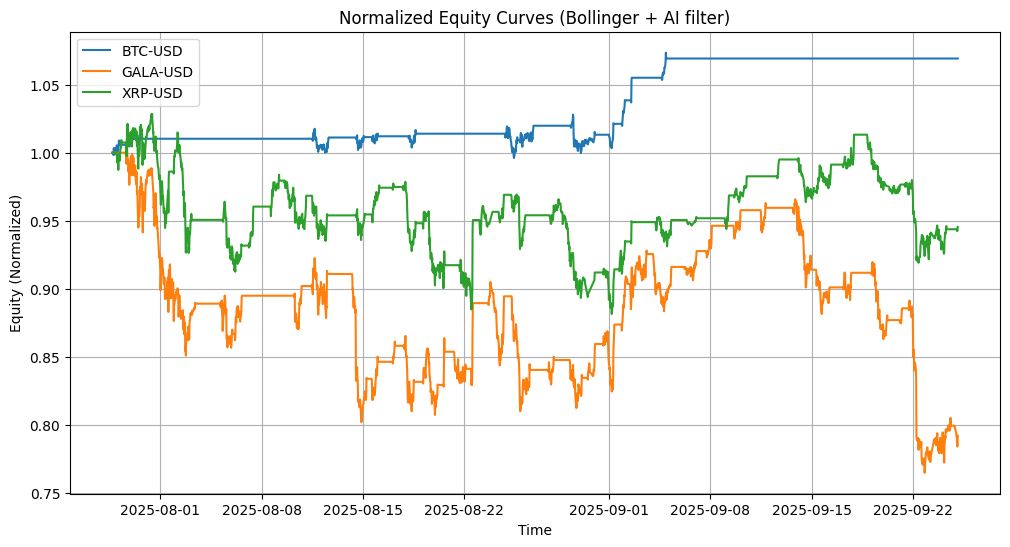

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
for sym, pf in results.items():
    norm_eq_curve = pf.value() / pf.value().iloc[0]
    plt.plot(norm_eq_curve, label=sym)

plt.title('Normalized Equity Curves (Bollinger + AI filter)')
plt.xlabel('Time')
plt.ylabel('Equity (Normalized)')
plt.legend()
plt.grid(True)
plt.show()

## Next steps

- Tune label threshold, horizon, model hyperparameters.
- Consider training on combined multi-coin dataset for better generalization.
- Add transaction costs & more realistic slippage models.
- Run walk-forward validation and cross-validation for robustness.
